In [ ]:
#| default_exp models.stsm

In [ ]:
#| export
import jax
import jax.numpy as jnp
from jaxtyping import Float, Array
from isssm.typing import GLSSM
import jax.scipy as jsp

In [ ]:
from isssm.glssm import simulate_glssm
import jax.random as jrn
import matplotlib.pyplot as plt
from isssm.kalman import kalman, smoother

# Basic Structural Time Series Model
> 2-nd order stationary time series with seasonal component

We implement the univariate model from Chapter 3.2.2 in [@Durbin2012Time] and refer the reader to their discussion.

In [ ]:
# | export
def stsm(
    x0: Float[Array, "m"], # initial state
    s2_mu: Float, # variance of trend innovations
    s2_nu: Float, # variance of velocity innovations
    s2_seasonal: Float, # variance of velocity innovations
    n: int, # number of time points
    Sigma_init: Float[Array, "m m"], # initial state covariance
    o2: Float, # variance of observation noise
    s_order: int, # order of seasonal component
) -> GLSSM:

    A = jnp.array([[1, 1], [0, 1]])
    B = jnp.array([[1, 0]])

    Sigma = jnp.diag(jnp.array([s2_mu, s2_nu]))


    if s_order >= 2:
        A_seasonal = jnp.block([
            [-jnp.ones((1,s_order - 1)), -jnp.ones((1,1))],
            [jnp.eye(s_order - 1), jnp.zeros((s_order - 1,1))]
        ])
        B_seasonal = (jnp.eye(s_order)[0])[None,:]
        Sigma_seasonal = jnp.diag(jnp.eye(s_order)[0] * s2_seasonal)

        A = jsp.linalg.block_diag(A, A_seasonal)
        B = jnp.concatenate((B, B_seasonal), axis=1)
        Sigma = jsp.linalg.block_diag(Sigma, Sigma_seasonal)
        
    
    A = jnp.broadcast_to(A, (n, s_order + 2, s_order + 2))
    B = jnp.broadcast_to(B, (n+1, 1, s_order + 2))
    Sigma = jnp.broadcast_to(Sigma, (n, s_order + 2, s_order + 2))
    Sigma = jnp.concatenate((Sigma_init[None, :, :], Sigma), axis=0)

    Omega = jnp.broadcast_to(jnp.diag(jnp.array([o2])), (n + 1, 1, 1))

    return GLSSM(x0, A, Sigma, B, Omega)

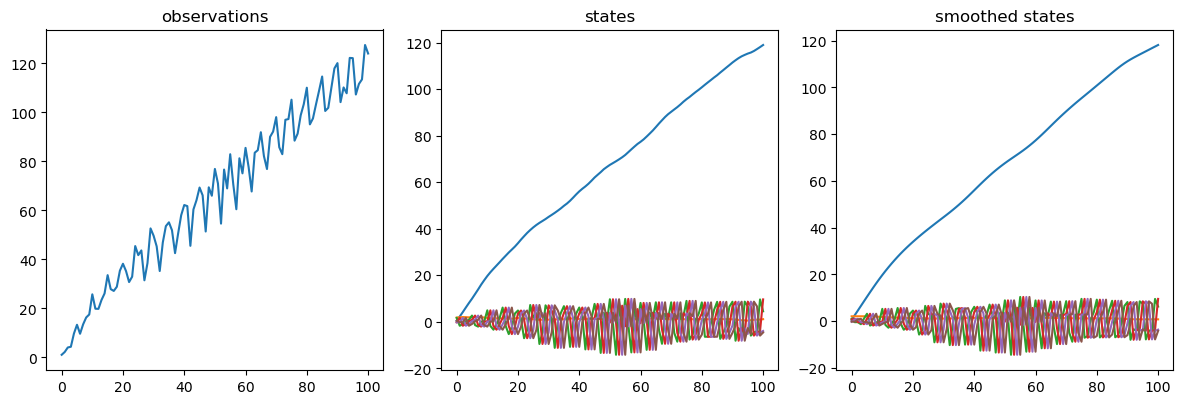

In [ ]:
s_ord = 4
glssm = stsm(jnp.zeros(2 + s_ord), 0., .01, 1., 100, jnp.eye(2 + s_ord), 1., s_ord)
key = jrn.PRNGKey(534512423)
key, subkey = jrn.split(key)
(x,), (y,) = simulate_glssm(glssm, 1, subkey)

x_smooth, _  = smoother(kalman(y, glssm), glssm.A)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()
axs[0].set_title("observations")
axs[0].plot(y)
axs[1].set_title("states")
axs[1].plot(x)
axs[2].set_title("smoothed states")
axs[2].plot(x_smooth)
plt.show()